In [1]:
from mne.filter import filter_data
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import pyedflib
import numpy as np
from datetime import timedelta
from scipy.signal import find_peaks_cwt
from scipy.stats import spearmanr
import time
from fileManagement import readData

from os import listdir
    #method listdir() returns a list containing the names of the entries in the directory given by path.
from os.path import isfile, join
    #returns true if file in path is an existing regular file

In [2]:
## !! set correct working directory
import os
# path="/Volumes/Projects_div3/ADBS"
path = "Y:/ADBS"
os.chdir(path)
os.getcwd() #check

'Y:\\ADBS'

In [3]:
# prepare ESM export from server
esm = df = pd.read_stata(path+'/esmDataPilot/PRDB_20180913T105337/SANPAR_BE.dta',convert_categoricals = False)
esm = esm[['subjno', 'mood_well', 'mood_down', 'mood_fright', 'mood_tense', 'phy_sleepy', 'phy_tired',
       'mood_cheerf', 'mood_relax', 'thou_concent', 'pat_hallu', 'loc_where',
       'soc_who', 'soc_who02', 'soc_who03', 'act_what', 'act_what02',
       'act_what03', 'act_norpob', 'sanpar_been', 'sanpar_stil',
       'sanpar_spreken', 'sanpar_lopen', 'sanpar_tremor', 'sanpar_traag',
       'sanpar_stijf', 'sanpar_spann', 'sanpar_beweeg', 'sanpar_onoff',
       'sanpar_medic', 'beep_disturb', '_datetime', '_datetime_e', 'dayno_n', 'beepno_n']]
esm['duration'] = esm['_datetime_e']-esm['_datetime']

mapNames={}
for i in range(20):
    mapNames[9009989+i]=110001+i

esm['castorID'] = [mapNames[e] for e in esm['subjno']]

C:\ProgramData\Miniconda3\envs\p3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Miniconda3\envs\p3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [4]:
esm.keys()

Index(['subjno', 'mood_well', 'mood_down', 'mood_fright', 'mood_tense',
       'phy_sleepy', 'phy_tired', 'mood_cheerf', 'mood_relax', 'thou_concent',
       'pat_hallu', 'loc_where', 'soc_who', 'soc_who02', 'soc_who03',
       'act_what', 'act_what02', 'act_what03', 'act_norpob', 'sanpar_been',
       'sanpar_stil', 'sanpar_spreken', 'sanpar_lopen', 'sanpar_tremor',
       'sanpar_traag', 'sanpar_stijf', 'sanpar_spann', 'sanpar_beweeg',
       'sanpar_onoff', 'sanpar_medic', 'beep_disturb', '_datetime',
       '_datetime_e', 'dayno_n', 'beepno_n', 'duration', 'castorID'],
      dtype='object')

In [5]:
# create list of files per L/R/chest from directory (mypath)

leftSensors = ['13797','13799','13794']
rightSensors = ['13805','13801','13793']
chestSensors = ['13804','13792','13803']

featureWindowLength=60
windowLength=60
esmWindowLength=15

mypath = path+'/MOX/110001/'
bdffiles = [f for f in listdir(mypath) if isfile(join(mypath,f)) and f[0]!='_' and f[-3:] =='edf']
#bdffiles are the files in mypath, not directories

leftFiles = []
rightFiles = []
chestFiles = []

for f in bdffiles:
    if f[0:5] in leftSensors:
        leftFiles.append(f)
    elif f[0:5] in rightSensors:
        rightFiles.append(f)
    elif f[0:5] in chestSensors:
        chestFiles.append(f)

leftFiles=sorted(leftFiles)
rightFiles=sorted(rightFiles)
chestFiles=sorted(chestFiles)

In [2]:
leftFiles

NameError: name 'leftFiles' is not defined

In [28]:
a=readData(leftFiles[0])

969.1920804977417
144.27579975128174


In [39]:
testL,testR,testC = extractAllSensors([leftFiles[1]],[rightFiles[1]],[chestFiles[2]])

13799_20180828_075206.edf


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  


13801_20180828_075146.edf
13792_20180828_075223.edf


In [6]:
def extractAllSensors(leftFiles,rightFiles,chestFiles,featureWindowLength=60):
    # Read in the three list of files
    #Process leftWristData
    leftWristDF=[]
    rightWristDF=[]
    chestDF=[]
    
    for file in leftFiles:
        print(file)
        labels, timeStamps, data, sr = readData(file) ## as input instead: leftFiles
    #Could be left wrist specific or general
        alignedTimes, leftWristFeatures, labels = extractFeatures(data, timeStamps, sr, featureWindowLength)
        labels=[l + 'L' for l in labels]
        if leftWristDF is None:
            leftWristDF=pd.DataFrame(leftWristFeatures.T,columns=labels,index=alignedTimes)
        else:
            leftWristDF.append(pd.DataFrame(leftWristFeatures.T,columns=labels,index=alignedTimes))
    
    # Same for right wrist
    for file in rightFiles:
        print(file)
        labels, timeStamps, data, sr = readData(file)
        #Could be right wrist specific or general
        alignedTimes, rightWristFeatures, labels = extractFeatures(data, timeStamps, sr, featureWindowLength)
        labels=[l + 'R' for l in labels]
        if rightWristDF is None:
            rightWristDF=pd.DataFrame(rightWristFeatures.T,columns=labels,index=alignedTimes)
        else:
            rightWristDF.append(pd.DataFrame(rightWristFeatures.T,columns=labels,index=alignedTimes))
    # Same for chest
    for file in chestFiles:
        print(file)
        labels, timeStamps, data, sr = readData(file)
        #Could be chest specific or general
        alignedTimes, chestFeatures, labels = extractFeatures(data, timeStamps, sr, featureWindowLength)
        labels=[l + 'C' for l in labels]
        if chestDF is None:
            chestDF=pd.DataFrame(chestFeatures.T,columns=labels,index=alignedTimes)
        else:
            chestDF.append(pd.DataFrame(chestFeatures.T,columns=labels,index=alignedTimes))
    
    leftWristDF = pd.concat((leftWristDF[:]))
    rightWristDF = pd.concat((rightWristDF[:]))
    chestDF = pd.concat((chestDF[:]))
    
    return leftWristDF,rightWristDF,chestDF    

In [8]:
def extractFeatures(data, timeStamps, sr, windowLength=60):
    #Filter data between 4 and 8 Hz
    #filtData = filter_data(data, sr, 4,8)

    #Extract some sort of feature for all windows and corresponding time stamps
    numSamples=data.shape[1]
    # Getting number and names of features
    tremorNames, _ = tremorFeatures(data[:,:windowLength*sr], sr)
    bradyNames, _ = bradykinesiaFeatures(data[:,:windowLength*sr], sr)
    
    
    features=np.zeros((len(tremorNames) + len(bradyNames),int(numSamples/(windowLength*sr))))
    alignedTimes=[]
    for i,win in enumerate(range(0,numSamples,windowLength*sr)):
        if i<features.shape[1]:
            #Average power per channel
            #features[:,i]=np.mean(filtData[:,win:win+windowLength*sr]**2,axis=1)
            _, features[:len(tremorNames),i] = tremorFeatures(data[:,win:win+windowLength*sr],sr)
            _, features[len(tremorNames):,i] = bradykinesiaFeatures(data[:,win:win+windowLength*sr],sr)
            # Add the power between 3.6 and 9.4
            #Timestamp at beginning of each window
            alignedTimes.append(timeStamps[win])
    return alignedTimes, features, tremorNames + bradyNames

In [9]:
def tremorFeatures(windowData,sr):
    gyroChannel={'X':3,'Y':4,'Z':5} # gyro is xyz 3-4-5
    freq = np.fft.rfftfreq(windowLength*sr, d=1./sr)
    selected=np.logical_and(freq>3.5,freq<7.5)
    features=[]
    featureNames=[]
    for ch in gyroChannel:
        spec = np.log(np.abs(np.fft.rfft(windowData[gyroChannel[ch],:])))
        features.append(np.sum(spec[selected]))
        featureNames.append('BandPower' + ch)
    return featureNames, features

In [10]:
def bradykinesiaFeatures(windowData,sr):
    features=[]
    featureNames=[]
    accelerometerChannel={'X':0,'Y':1,'Z':2} # assuming acc xyz 0-1-2 is
    #for ch in accelerometerChannel.keys():
        #peaks=find_peaks_cwt(windowData[accelerometerChannel[ch],:],np.arange(1,10))
        #peaks=[1,2,3]
        #features.append(len(peaks))
        #featureNames.append('#Movements' + ch) 
        
    maxAcc=np.max(np.abs(windowData[:,0:3]))
    features.append(maxAcc)
    featureNames.append('MaximumAcceleration')
        
    #features.append(np.max(windowData[0:3,:]))
    #featureNames.append('MaxMovement')
    return featureNames, features

In [15]:
testL.keys()

Index(['BandPowerXL', 'BandPowerYL', 'BandPowerZL', 'MaximumAccelerationL'], dtype='object')

In [14]:
esm.keys()

Index(['subjno', 'mood_well', 'mood_down', 'mood_fright', 'mood_tense',
       'phy_sleepy', 'phy_tired', 'mood_cheerf', 'mood_relax', 'thou_concent',
       'pat_hallu', 'loc_where', 'soc_who', 'soc_who02', 'soc_who03',
       'act_what', 'act_what02', 'act_what03', 'act_norpob', 'sanpar_been',
       'sanpar_stil', 'sanpar_spreken', 'sanpar_lopen', 'sanpar_tremor',
       'sanpar_traag', 'sanpar_stijf', 'sanpar_spann', 'sanpar_beweeg',
       'sanpar_onoff', 'sanpar_medic', 'beep_disturb', '_datetime',
       '_datetime_e', 'dayno_n', 'beepno_n', 'duration', 'castorID'],
      dtype='object')

In [23]:
def alignFeaturesESM(listOfDF,esmFrame,esmColumns,esmWindowLength=15):
    
    combinedColumns=esmColumns
    for featureFrame in listOfDF:
        combinedColumns= combinedColumns + featureFrame.keys().tolist()  
    esmFeatures=pd.DataFrame(columns=combinedColumns) # Create new empty dataframe with feature and esm columns

    hop=np.mean(np.diff(listOfDF[0].index))
    for beep in range(esmFrame.shape[0]): #Loop through all the ESM Beeps

        beepTime=esmFrame['_datetime'][beep] # Get the corresponding time
        
        esmData=np.matlib.repmat(esmFrame.iloc[beep][esmColumns],esmWindowLength,1)
        combined=esmData
        
        subIndex=[beepTime-hop*t for t in range(esmWindowLength)][::-1]
        for featureFrame in listOfDF:
        
        
            timediff = np.min(np.abs(featureFrame.index-beepTime)) 
            # Find corresponding moment for beep time in the sensor data
            #print(timediff)
            if timediff>timedelta(minutes=esmWindowLength):
                # If corresponding time is too far off, remove beep
                #print("Couldn't find corresponding sensor data")
                continue
            pos=np.argmin(np.abs(featureFrame.index-beepTime))
            # For the smallest time difference find the position in the sensor data
            if pos>esmWindowLength:
                featColumns=featureFrame.keys().tolist() #The names of the features                
                featData=featureFrame.iloc[pos-esmWindowLength:pos][featColumns].values
                # Get corresponding timestamps
                
                # Repeat ESM data for each data point in the window
                combined=np.concatenate((combined,featData),axis=1)
                #Combine ESM & feature data
        if combined.shape[1]==len(combinedColumns):
            esmFeatures=esmFeatures.append(pd.DataFrame(combined,columns=combinedColumns,index=subIndex))
                #Append combined data to the dataframe
    return esmFeatures

In [43]:
esmFeatures

,subjno,mood_well,mood_down,mood_fright,mood_tense,phy_sleepy,phy_tired,mood_cheerf,mood_relax,thou_concent,...,BandPowerZL,MaximumAccelerationL,BandPowerXR,BandPowerYR,BandPowerZR,MaximumAccelerationR,BandPowerXC,BandPowerYC,BandPowerZC,MaximumAccelerationC
2018-08-28 08:55:11,9009989,7,1,1,1,1,1,7,7,7,...,1068.01,1.68003,1532.1,1244.38,1375.5,1.96003,1427.22,1453.44,1194.86,4.48007
2018-08-28 08:56:11,9009989,7,1,1,1,1,1,7,7,7,...,1229.62,1.82003,1530.39,1312.02,1376.97,10.4302,1481.49,1516.88,1267.43,0.964385
2018-08-28 08:57:11,9009989,7,1,1,1,1,1,7,7,7,...,1171.38,2.87004,1481.58,1182.1,1327.49,0.880154,1284.57,1298.56,985.477,3.99006
2018-08-28 08:58:11,9009989,7,1,1,1,1,1,7,7,7,...,1096.97,1.68003,1488.61,1247.22,1329.51,0.829859,1282.51,1226.83,1026.46,5.39008
2018-08-28 08:59:11,9009989,7,1,1,1,1,1,7,7,7,...,1107.3,1.54002,1532.54,1257.14,1380.49,8.75013,1390.14,1342,1098.01,2.52004
2018-08-28 09:00:11,9009989,7,1,1,1,1,1,7,7,7,...,1071.79,0.910014,1565.86,1347.43,1441.64,4.69007,1316.18,1225.88,961.721,1.05002
2018-08-28 09:01:11,9009989,7,1,1,1,1,1,7,7,7,...,1043.69,2.03003,1586.36,1316.82,1391.48,3.43005,1290.68,1163.08,928.871,2.03003
2018-08-28 09:02:11,9009989,7,1,1,1,1,1,7,7,7,...,1011.31,2.17003,1487.18,1221.62,1394.93,5.60008,1277.06,1160.31,928.769,1.61002
2018-08-28 09:03:11,9009989,7,1,1,1,1,1,7,7,7,...,1009.14,1.61002,1462.02,1202.67,1370.94,0.867214,1227.49,1099.53,931.586,0.991974
2018-08-28 09:04:11,9009989,7,1,1,1,1,1,7,7,7,...,1218.74,2.17003,1886.47,1531.28,1540.07,4.13006,1274.17,1268.03,954.102,1.26002


In [40]:
#Align them to the ESM File
esmFeatures = alignFeaturesESM([testL,testR,testC],esm[esm['castorID']==110001],esm.keys().tolist(),esmWindowLength=15)

#esmFeatures = esmFeatures.dropna() # Drop all lines with missing values, this definitely needs to be refined for real data

# Save the dataframe
esmFeatures.to_csv('/Users/jeroenhabets/Desktop/python_code/pilot_testdata/test110001.csv')

0 days 00:00:05
0 days 00:00:25
0 days 00:00:12
0 days 00:00:21
0 days 00:00:01
0 days 00:00:22
0 days 00:00:04
0 days 00:00:24
0 days 00:00:13
0 days 00:00:12
0 days 00:00:28
0 days 00:00:05
0 days 00:00:06
0 days 00:00:26
0 days 00:00:11
0 days 00:00:24
0 days 00:00:16
0 days 00:00:07
0 days 00:00:19
0 days 00:00:21
0 days 00:00:02
0 days 09:25:08
Couldn't find corresponding sensor data
0 days 09:24:28
Couldn't find corresponding sensor data
0 days 09:24:51
Couldn't find corresponding sensor data
0 days 13:18:26
Couldn't find corresponding sensor data
0 days 13:17:46
Couldn't find corresponding sensor data
0 days 13:18:09
Couldn't find corresponding sensor data
0 days 15:37:38
Couldn't find corresponding sensor data
0 days 15:36:58
Couldn't find corresponding sensor data
0 days 15:37:21
Couldn't find corresponding sensor data
0 days 17:14:47
Couldn't find corresponding sensor data
0 days 17:14:07
Couldn't find corresponding sensor data
0 days 17:14:30
Couldn't find corresponding sens

In [ ]:
### END OF DATA PREPARATION

In [48]:
### Simple analysis

# Spearman Correlations
r, p = spearmanr(esmFeatures['stress'],(esmFeatures['BandPowerXR']+esmFeatures['BandPowerXL'])/2)
print('Spearman correlation of r = %f with a p-value of %f' % (r, p))

Spearman correlation of r = 0.159789 with a p-value of 0.020523


In [241]:
### Use Machine Learning to predict some variable from the esm

# Linear Regression
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
# Fitting the linear regression to the data
lr.fit(esmFeatures[['BandPowerXR','BandPowerYL', '#MovementsXL']].values,esmFeatures['stress'])
# Looking at model parameters
# Regression weights
print('Weights are %f, %f, %f ' % (lr.coef_[0], lr.coef_[1], lr.coef_[2]))
# Intercept
print('Intercept is %f' % lr.intercept_)

# Predict target variable based on input data (should be unseen data)
prediction = lr.predict(esmFeatures[['BandPowerXR','BandPowerYL', '#MovementsXL']].values)

Weights are 0.010902, -0.005863, 0.098696 
Intercept is -3.290468


NameError: name 'lr' is not defined

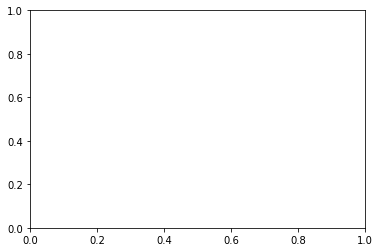

In [91]:
### Data visualization
# Bar plot
fig,ax = plt.subplots()
ax.bar(range(3), lr.coef_,color='r',width=0.4)
ax.bar(np.arange(3)+0.4, lr.coef_+0.01, color='b',width=0.4)
plt.xlabel('Features')
plt.ylabel('Weight')
plt.title('Linear Regression Weights')
plt.xticks(range(3),['BandPowerXR','BandPowerYL', '#MovementsXL'])
plt.yticks(np.arange(0,0.1,0.02))
plt.savefig('weights.png',dpi=60)
plt.show()

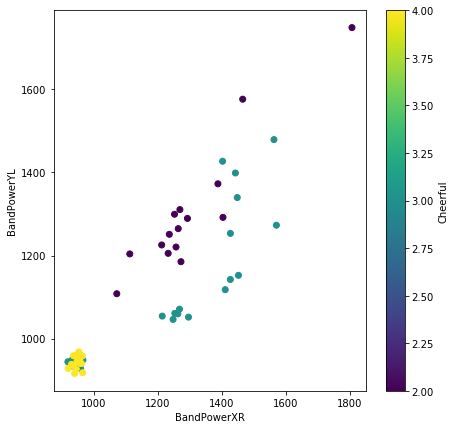

In [323]:
# Scatter Plot
feature1='BandPowerXR'
feature2='BandPowerYL'
fig, ax = plt.subplots(figsize=(7,7))
s1 = ax.scatter(esmFeatures[feature1], esmFeatures[feature2], c=esmFeatures['cheerful'])
plt.xlabel(feature1)
plt.ylabel(feature2)
fig.colorbar(s1,label='Cheerful')
plt.show()

(array([  4.,   0.,  15.,   0.,  30.,   0.,  20.,   0.,   4.,   2.]),
 array([  5. ,   5.5,   6. ,   6.5,   7. ,   7.5,   8. ,   8.5,   9. ,
          9.5,  10. ]),
 <a list of 10 Patch objects>)

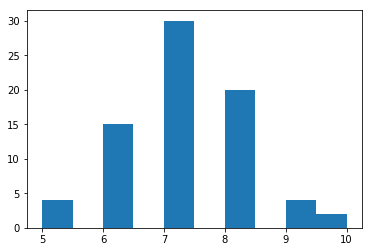

In [325]:
# Histogram
plt.hist(esmFeatures['#MovementsXR'])

In [326]:
# Principal Component Analysis
def pca(data):
    # Calculate Covariance Matrix
    cov=np.cov(data.T)
    # Calculate Eigenvalues and Eigenvectors
    w, v = np.linalg.eig(cov)
    # Sort them
    s= np.argsort(w)[::-1]
    return v[:,s]

/home/cherff/miniconda2/envs/3.6/lib/python3.6/site-packages/numpy/core/numeric.py:583: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


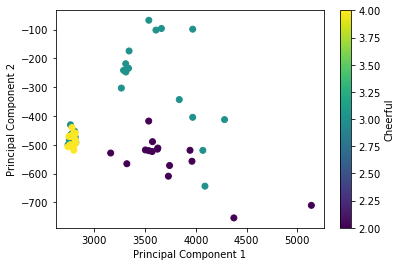

In [369]:
# Could also be done in only sensor/esm spaces
esmEigenVectors = pca(esmFeatures.values.astype(float))
transformedFeatureSpace =np.dot(esmEigenVectors[:,:2].T,esmFeatures.values.astype(float).T).T
s1 = plt.scatter(transformedFeatureSpace[:,0],transformedFeatureSpace[:,1],c=esmFeatures['cheerful'])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(s1, label = 'Cheerful')
plt.show()

In [237]:
## It is very easy to use a more powerful Machine Learning algorithm

from sklearn.ensemble import GradientBoostingRegressor
est = GradientBoostingRegressor()
# Fitting the regression model to our data
est.fit(esmFeatures[['BandPowerXR','BandPowerYL', '#MovementsXL']].values,esmFeatures['stress'])

# Interpreting the model
print(est.feature_importances_)

# Predict target variable based on input data (should be unseen data)
prediction = est.predict(esmFeatures[['BandPowerXR','BandPowerYL', '#MovementsXL']].values)

[ 0.49260492  0.46772674  0.03966834]


In [222]:
from scipy.stats import spearmanr
r,p=spearmanr(alignedFeatures['AccX'].values.tolist(),alignedFeatures['cheerful'].values.tolist(),nan_policy='omit')
print(r,p)

-0.438833570413 8.205319799493544e-05


In [83]:
######### Exploring the sensor data

signal_labels, timeStamps, data, sr = readData(leftWristFile)

#filtData = filter_data(data, sr, 4,8)

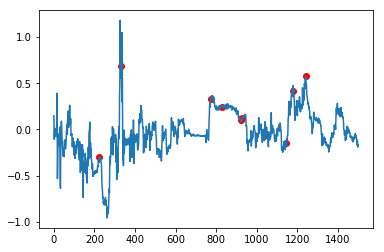

[ 224  329  775  829  921  928 1040 1045 1145 1180 1241]


In [247]:
#Extract some sort of feature for all windows and corresponding time stamps
# Peak detection


channel=3
numSamples=data.shape[1]
windowLength=60

win=0
windowData = data[:,win:win+featureWindowLength*sr]

peaks=find_peaks_cwt(windowData[channel,:],np.arange(40,50))

#Maximum for bradykinesia recognition
mMovement = np.max(windowData[3:6,:])
numberOfPeaks = len(peaks)
averageDuration = np.mean(np.diff(peaks))/sr


plt.plot(windowData[channel,:])
plt.scatter(peaks,windowData[channel,peaks],c='r')
plt.show()
print(peaks)

In [281]:
### Experiments with Orientation estimation
signal_labels, timeStamps, sigbufs, sr = readData(leftWristFile)

In [287]:
### Transform Gyro data into orientation estimation
from madgwickahrs import MadgwickAHRS
mw = MadgwickAHRS(sampleperiod=1/sr)
euler = np.zeros((3,sigbufs.shape[1]))
for sample in range(sigbufs.shape[1]):
    mw.update_imu(sigbufs[6:,sample],sigbufs[3:6,sample])
    euler[:,sample] = mw.quaternion.to_euler123()

/home/cherff/workspace/ADBS/quaternion.py:97: RuntimeWarning: invalid value encountered in arcsin
  pitch = np.arcsin(2*(self[1]*self[3] + self[0]*self[1]))


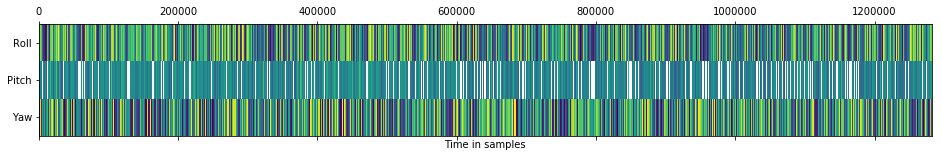

In [298]:
plt.matshow(euler,aspect='auto')
plt.yticks([0,1,2],['Roll', 'Pitch', 'Yaw'])
plt.xlabel('Time in samples')
plt.show()